<a href="https://colab.research.google.com/github/oreilly-japan/ml-at-work/blob/master/chap10/Kevin_Hillstrom_MineThatData_E-MailAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-947-2.gif)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

In [1]:
# 이 셀은 한글 폰트 설치시에만 실행하며,
# 실행 후 런타임을 다시 시작합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,413 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

In [1]:
import urllib.request
csv_url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
csv_filename = "source_data.csv"
with open(csv_filename, "w") as fp:
    data = urllib.request.urlopen(csv_url).read()
    fp.write(data.decode("ascii"))

In [2]:
import pandas as pd
source_df = pd.read_csv(csv_filename)
source_df.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
6,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
7,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
9,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0


In [3]:
source_df.groupby(["mens","womens"]).count()

recency  history_segment  history  ...  visit  conversion  spend
mens womens                                     ...                          
0    1         28734            28734    28734  ...  28734       28734  28734
1    0         28818            28818    28818  ...  28818       28818  28818
     1          6448             6448     6448  ...   6448        6448   6448

[3 rows x 10 columns]

In [4]:
mailed_df = source_df[source_df["segment"] != "No E-Mail"]
mailed_df = mailed_df.reset_index(drop=True)
mailed_df.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
5,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
6,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
7,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
8,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0
9,7,5) $500 - $750,548.91,0,1,Urban,1,Phone,Womens E-Mail,1,0,0.0


In [5]:
dummied_df = pd.get_dummies(mailed_df[["zip_code", "channel"]], drop_first=True)
feature_vector_df = mailed_df.drop(
    ["history_segment", "zip_code", "channel", 
     "segment", "visit", "conversion", "spend"], 
     axis=1)
feature_vector_df = feature_vector_df.join(dummied_df)
feature_vector_df.head(10)

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0
1,7,180.65,0,1,1,1,0,0,1
2,9,675.83,1,0,1,0,0,0,1
3,2,45.34,1,0,0,0,1,0,1
4,6,134.83,0,1,0,1,0,1,0
5,9,280.20,1,0,1,1,0,1,0
6,9,46.42,0,1,0,0,1,1,0
7,9,675.07,1,1,1,0,0,1,0
8,10,32.84,0,1,1,0,1,0,1
9,7,548.91,0,1,1,0,1,1,0


In [6]:
from sklearn.model_selection import train_test_split

is_treat_list = list(mailed_df["segment"] == "Mens E-Mail")
is_cv_list = list(mailed_df["visit"] == 1)

train_is_cv_list, test_is_cv_list, train_is_treat_list, test_is_treat_list, train_feature_vector_df, test_feature_vector_df = train_test_split(is_cv_list, is_treat_list, feature_vector_df, test_size=0.5,  random_state=42)


In [7]:
from sklearn.linear_model import LogisticRegression

treat_model = LogisticRegression(C=0.01, max_iter=1000)
control_model = LogisticRegression(C=0.01, max_iter=1000)

train_sample_num = len(train_is_cv_list)

treat_is_cv_list = [train_is_cv_list[i] 
                    for i in range(train_sample_num) if train_is_treat_list[i] == True]
treat_feature_vector_list = train_feature_vector_df[train_is_treat_list]

control_is_cv_list = [train_is_cv_list[i] 
                      for i in range(train_sample_num) if train_is_treat_list[i] == False]
control_feature_vector_list = train_feature_vector_df[list(map(lambda a:a == False ,train_is_treat_list))]

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, max_iter=1000)

In [8]:
from operator import itemgetter
    
treat_score = treat_model.predict_proba(test_feature_vector_df)
control_score = control_model.predict_proba(test_feature_vector_df)
score_list = treat_score[:,1] / control_score[:,1]

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2),reverse=True)
    

treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

    # 전환율의 라와 실험군의 수를 곱해서 lift를 산출
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

Text(0, 0.5, '전환율')

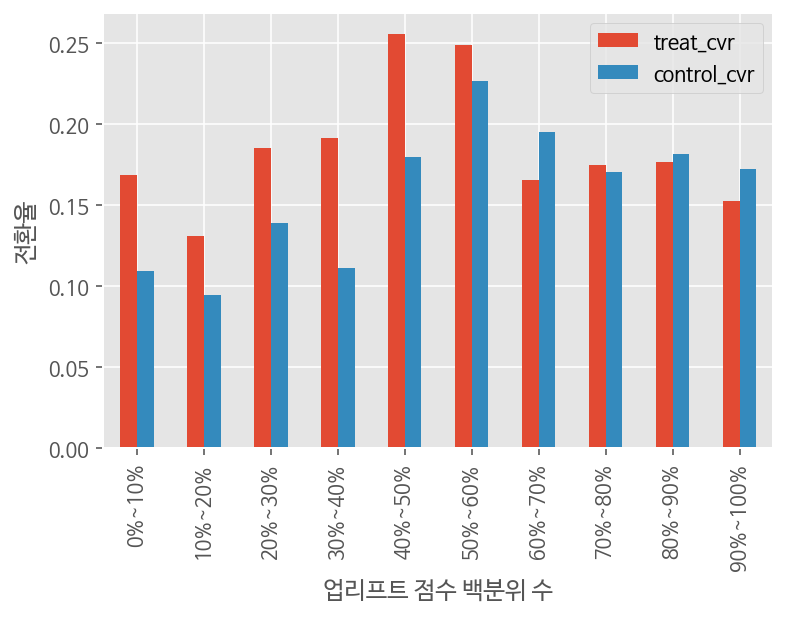

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic')
%matplotlib inline 
%config InlineBackend.figure_formats = {'png', 'retina'}

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

quantile_data = []
for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)
    
    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)
    
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    
    quantile_data.append([treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr])
        
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("업리프트 점수 백분위 수")
plt.ylabel("전환율")

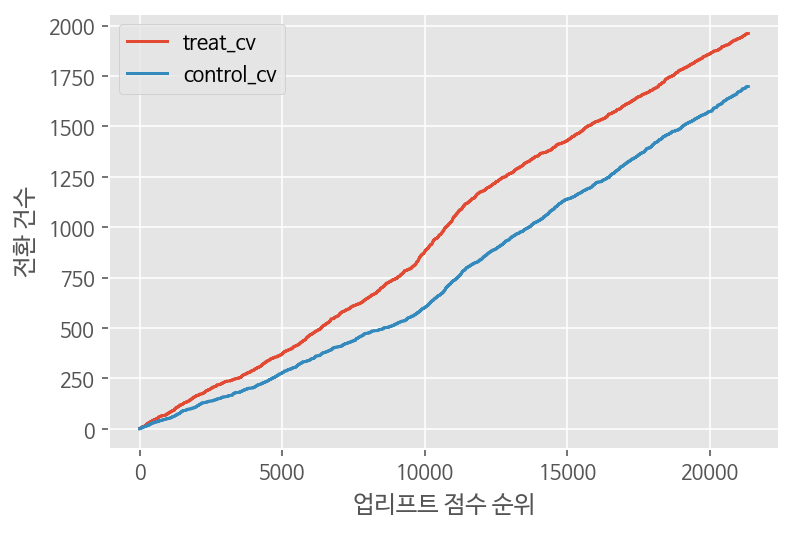

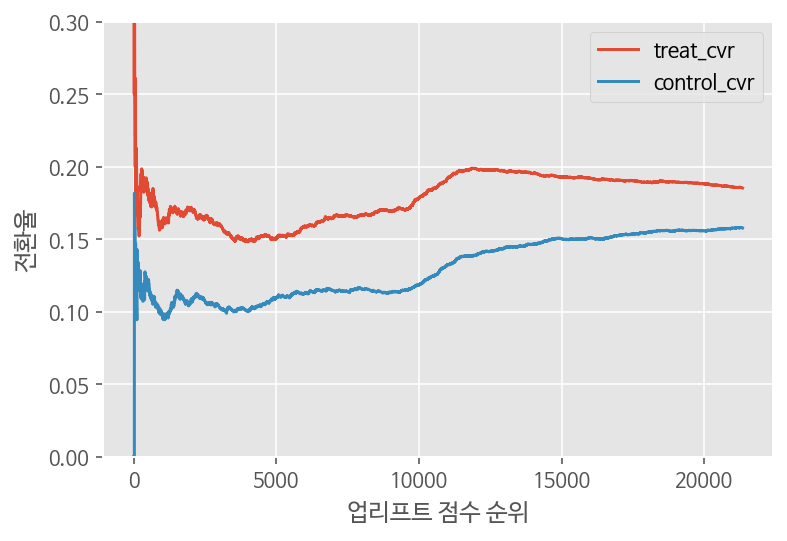

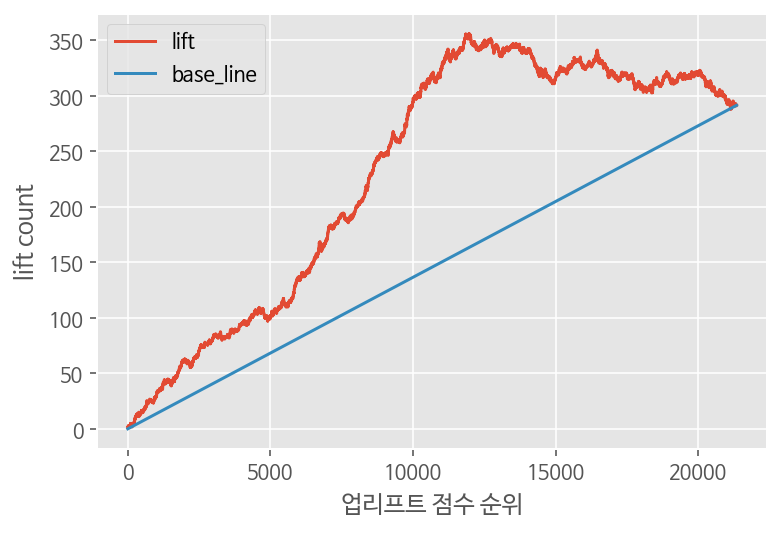

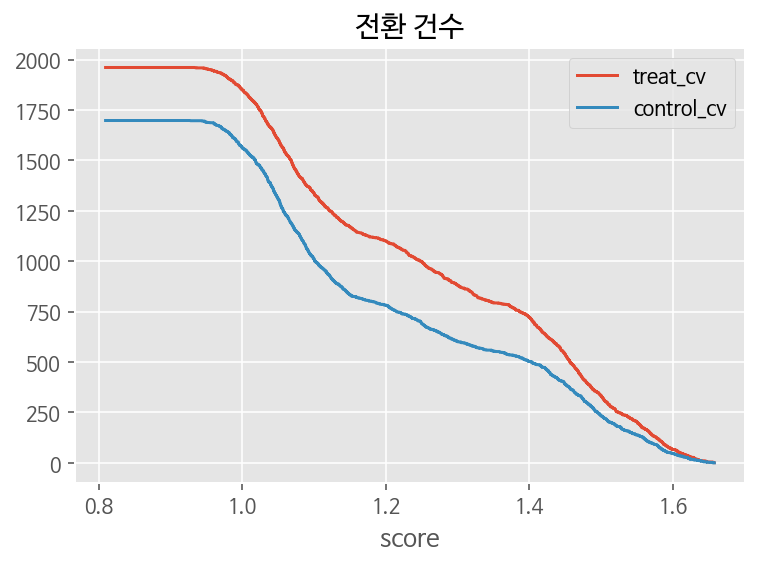

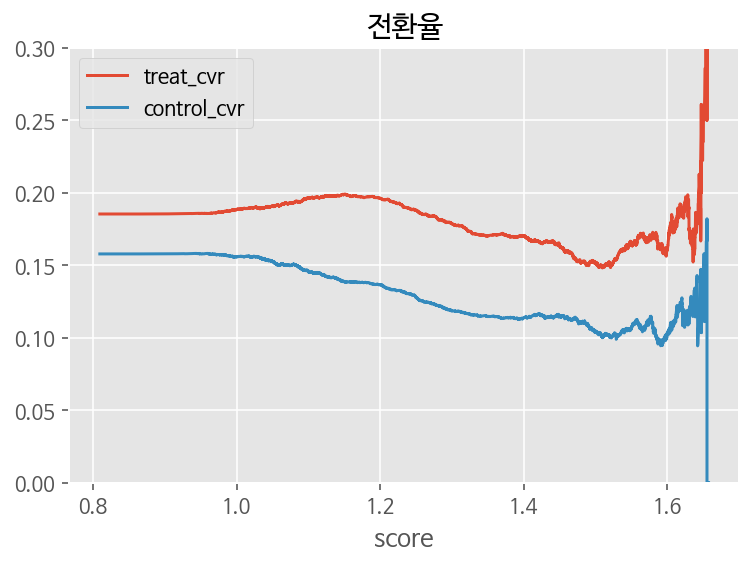

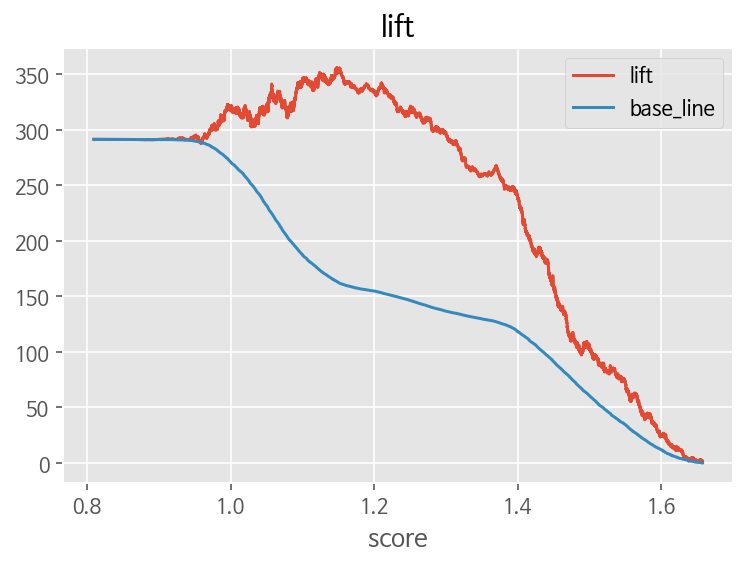

In [10]:
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]


# 베이스라인 추가
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환 건수")

df.plot(y=["treat_cvr", "control_cvr"], ylim=[0, 0.3])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환율")

df.plot(y=["lift", "base_line"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("lift count")

df.plot(y=["treat_cv", "control_cv"], x="score", title="전환 건수")
df.plot(y=["treat_cvr", "control_cvr"], ylim=[0, 0.3], x="score", title="전환율")
df.plot(y=["lift", "base_line"], x="score", title="lift")